In [19]:
import numpy as np
import pandas as pd

In [20]:
import tensorflow as tf

BATCH_SIZE = 40
IMG_WIDTH  = 128 
IMG_HEIGHT = 128 
DATASET_DIR = "../input/animals10/raw-img"

In [21]:
animals_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  DATASET_DIR,
  seed = 42,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = BATCH_SIZE, 
  labels = 'inferred'
)

Found 26179 files belonging to 10 classes.


In [22]:
def countTuplesByClass(x,y):
    dataset_unbatched = tuple(x.unbatch())
    labels = []
    for (image,label) in dataset_unbatched:
        labels.append(label.numpy())
    labels = pd.Series(labels)
    counts = labels.value_counts()
    
    for i in range(len(counts)):
        print(y[i] + "\t\t" + str(counts[i]))

In [23]:
animals_names = animals_dataset.class_names
animals_names

['cane',
 'cavallo',
 'elefante',
 'farfalla',
 'gallina',
 'gatto',
 'mucca',
 'pecora',
 'ragno',
 'scoiattolo']

In [24]:
countTuplesByClass(animals_dataset,animals_names)

2022-10-12 12:43:07.582785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
2022-10-12 12:43:08.151095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2022-10-12 12:43:09.294849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2022-10-12 12:43:11.009612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
2022-10-12 12:43:11.510428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
2022-10-12 12:43:11.536653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
2022-10-12 12:43:12.546519: W tens

cane		4863
cavallo		2623
elefante		1446
farfalla		2112
gallina		3098
gatto		1668
mucca		1866
pecora		1820
ragno		4821
scoiattolo		1862


In [25]:
animals_dataset.take(1)

<TakeDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
training_generator = tf.keras.preprocessing.image_dataset_from_directory(
  DATASET_DIR,
  seed = 37,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = BATCH_SIZE, 
  labels = None, 
  validation_split = 0.4,
  subset = 'training'
)

validation_generator = tf.keras.preprocessing.image_dataset_from_directory(
  DATASET_DIR,
  seed = 37,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = BATCH_SIZE, 
  labels = None, 
  validation_split = 0.4,
  subset = 'validation'
)

## Simple Visualization

In [26]:
animals10_names = animals_dataset.class_names

2022-10-12 12:43:25.623476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


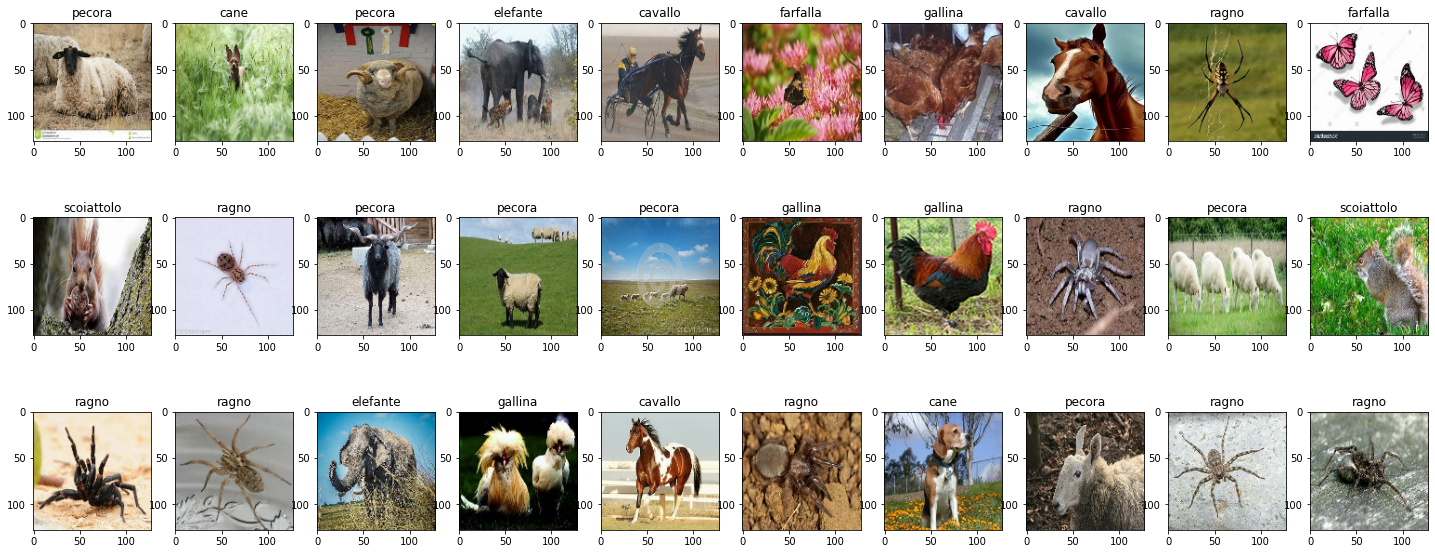

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 28))

for images, labels in animals_dataset.take(1):
    for i in range(30):
        ax = plt.subplot(8, 10, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(animals10_names[labels[i]])